# Biology 1B - Mousey 

## Table of Contents

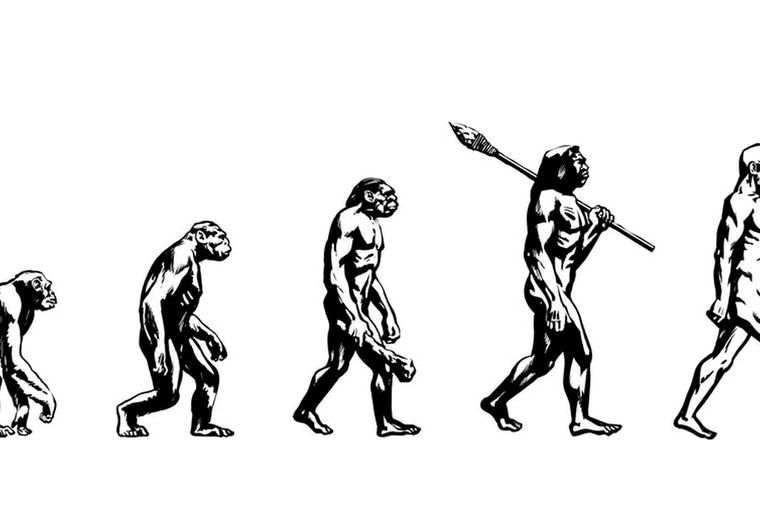

In [6]:
from IPython.display import Image
Image(filename="bio1b.jpg")

* [Introduction to Jupyter Notebooks](#first-bullet)
* [Mousey Simulation](#second-bullet)
* [Questions](#bullet)
* [Submission](#-bullet)

##  Jupyter Notebooks

**Types of Cells**

There are two types of cells that we will be using today in Jupyter: code cells and markdown cells. Code cells are cells indicated with “In [ ]:” to the left of the cell. In these cells you can write you own code and run the code in the individual cell. Markdown cells hold text a majority of the time and do not have “In [ ]” to the left of the cell.

<style>
pre {
  font-size: 20px;
}
</style>

**Running Cells**

'Running' a codel cell is like pressing 'Enter' on a calculator once you've typed in an expression; it computes all of the expressions contained within the cell.
Here are the steps to running a code cell:
1.	Click on the cell.
a.	You will notice that there is a green box around the code cell you have clicked on
2.	You can do one of the following to run the cell:
<br />
•	press Shift + Enter
<br />
•	click Cell -> Run Cells in the toolbar at the top of the screen.
3.	You will see an asterisk (*) next to the code cell you are trying to run. This means that the code is running and will be done momentarily.

Practice Running the code cells below

In [7]:
print("Hello World")

Hello World


You should see "Hello World" printed below the code cell.In general, the output of running a cell is shown in the line immediately after it. 
<br />
Notice that markdown cells have no output.

# Mousey Simulation

Please run the following code cells.
After running the bottom two code cells, if you are unable to see the Grey and White Screen for the Simulation, Refresh your page and releoad the bottom two code cells.

In [2]:
%%capture
!pip install ipympl

%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
import time
import multiprocessing

In [3]:
output = widgets.Output()

migration_const = 1.0 / (1.0 - np.exp(-1.0))
    
class Geno(Enum):
    dd = 0
    Dd = 1
    DD = 2

def geno_to_pheno(geno):
    pheno = np.array(geno)
    pheno[geno == Geno.dd] = 'white'
    pheno[geno != Geno.dd] = 'black'
    return pheno

def report_geno_before_counts(geno, lava):
    sand_before_DD.value = sum(geno[~lava] == Geno.DD)
    sand_before_Dd.value = sum(geno[~lava] == Geno.Dd)
    sand_before_dd.value = sum(geno[~lava] == Geno.dd)
    lava_before_DD.value = sum(geno[lava] == Geno.DD)
    lava_before_Dd.value = sum(geno[lava] == Geno.Dd)
    lava_before_dd.value = sum(geno[lava] == Geno.dd)

def report_geno_after_counts_and_get_geno_dist(geno, lava, mortality_mask, settings):
    sand_after_DD.value = sum((geno[~lava] == Geno.DD) & ~mortality_mask[~lava])
    sand_after_Dd.value = sum((geno[~lava] == Geno.Dd) & ~mortality_mask[~lava])
    sand_after_dd.value = sum((geno[~lava] == Geno.dd) & ~mortality_mask[~lava])
    lava_after_DD.value = sum((geno[lava] == Geno.DD) & ~mortality_mask[lava])
    lava_after_Dd.value = sum((geno[lava] == Geno.Dd) & ~mortality_mask[lava])
    lava_after_dd.value = sum((geno[lava] == Geno.dd) & ~mortality_mask[lava])
    m = settings['mutation_rate']
    def apply_mutation_to_dist(p):
        nonlocal m
        return p * (1-m) + (1-p) * m
    s = settings['num_mice'] - (2*settings['mortality_count'])
    sand_D = apply_mutation_to_dist((2 * sand_after_DD.value + sand_after_Dd.value) / s)
    sand_d = apply_mutation_to_dist((2 * sand_after_dd.value + sand_after_Dd.value) / s)
    lava_D = apply_mutation_to_dist((2 * lava_after_DD.value + lava_after_Dd.value) / s)
    lava_d = apply_mutation_to_dist((2 * lava_after_dd.value + lava_after_Dd.value) / s)
    def hardy_weinberg(D, d):
        return (d ** 2, 2 * D * d, D ** 2)
    return (hardy_weinberg(sand_D, sand_d), hardy_weinberg(lava_D, lava_d))
    
def iterate_generation(x, y, geno, pheno, settings):
    # MOVEMENT
    lava = x > 0.5
    x += (np.random.random(settings['num_mice']) >= 0.95) * (np.random.random(settings['num_mice']) - 0.5) * 0.1
    y += (np.random.random(settings['num_mice']) >= 0.95) * (np.random.random(settings['num_mice']) - 0.5) * 0.1
    # Keep within bounding box
    x += (x < 0) * (~lava) * 2 * (0 - x)
    x -= (x > 0.5) * (~lava) * 2 * (x - 0.5)
    x += (x < 0.5) * (lava) * 2 * (0.5 - x)
    x -= (x > 1) * (lava) * 2 * (x - 1)
    y += (y < 0) * 2 * (0 - y)
    y -= (y > 1) * 2 * (y - 1)
    
    # MIGRATION
    # Choose indices to migrate + create mask of mice to flip
    migration_mask = np.zeros(x.shape)
    migration_mask[np.random.choice(np.nonzero(lava)[0], settings['migration_count'], replace=False)] = 1
    migration_mask[np.random.choice(np.nonzero(~lava)[0], settings['migration_count'], replace=False)] = 1
    x += (migration_mask) * 2 * (0.5 - x)
    
    # REPORT GENOTYPES
    report_geno_before_counts(geno, lava)
    
    # MORTALITY
    # Choose indices to die + create mask of mice to progenate
    white = pheno == 'white'
    mortality_mask = np.zeros(x.shape).astype(bool)
    # Choosing mice to kill
    p = lava.astype(float) + (white & lava) * ((1.0 / (1.0 - settings['selection_intensity'])) - 1)
    mortality_mask[np.random.choice(range(settings['num_mice']), settings['mortality_count'], replace=False, p=p/np.sum(p))] = True
    p = (~lava).astype(float) + (~white & ~lava) * ((1.0 / (1.0 - settings['selection_intensity'])) - 1)
    mortality_mask[np.random.choice(range(settings['num_mice']), settings['mortality_count'], replace=False, p=p/np.sum(p))] = True
    
    # REPORT GENOTYPES
    geno_dist = report_geno_after_counts_and_get_geno_dist(geno, lava, mortality_mask, settings)
    
    # REPRODUCTION & MUTATION
    geno[(~lava & mortality_mask)] = np.random.choice([Geno.dd, Geno.Dd, Geno.DD], settings['mortality_count'], p=geno_dist[0])
    geno[(lava & mortality_mask)] = np.random.choice([Geno.dd, Geno.Dd, Geno.DD], settings['mortality_count'], p=geno_dist[1])
    
    return x, y, geno
    
with output:
    plt.rcParams["figure.figsize"] = (6, 4)
    plt.rcParams["figure.constrained_layout.use"] = True
    fig = plt.figure()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axvspan(0, 0.5, facecolor='grey', alpha=0.7, zorder=1)
    plt.axvspan(0.5, 1, facecolor='black', alpha=0.7, zorder=1)
    plt.axis('off')
    scat = plt.scatter([], [])
    fig.canvas.draw()

settings_layout=widgets.Layout(width='50%')
speed_slider = widgets.FloatSlider(value=0.25, min=0.25, max=2, readout=False, layout=settings_layout)
num_mice_in = widgets.BoundedIntText(value=1000, min=0, max=10000, layout=settings_layout)
mutation_rate_in = widgets.BoundedFloatText(value=0.001, min=0, max=1, layout=settings_layout)
selection_intensity_in = widgets.BoundedFloatText(value=0.05, min=0, max=1, layout=settings_layout)
mortality_rate_in = widgets.BoundedFloatText(value=0.25, min=0, max=1, layout=settings_layout)
migration_rate_in = widgets.BoundedFloatText(value=0, min=0, max=1, layout=settings_layout)
labels = ['Simulation Speed', '# of Mice', 'Mutation Rate', 'Selection Intensity', 'Mortality Rate', 'Migration Rate']
settings_labels = widgets.VBox([widgets.Label(value=label) for label in labels])
settings = widgets.VBox([speed_slider, num_mice_in, mutation_rate_in, selection_intensity_in, mortality_rate_in, migration_rate_in])
simulate_button = widgets.Button(description='Simulate', layout=widgets.Layout(width='99%'))
reset_button = widgets.Button(description='Reset', layout=widgets.Layout(width='99%'))
clear_button = widgets.Button(description='Clear', layout=widgets.Layout(width='99%'))
debug = widgets.Textarea(layout=widgets.Layout(height='50%', width='99%'), value='') # TODO: Remove this when done with dev
control_bar = widgets.VBox([widgets.HBox([settings_labels, settings]), simulate_button, clear_button, reset_button, debug])

geno_layout=widgets.Layout(width='80%')
sand_before_DD = widgets.IntText(description='DD', value=0, layout=geno_layout)
sand_before_Dd = widgets.IntText(description='Dd', value=0, layout=geno_layout)
sand_before_dd = widgets.IntText(description='dd', value=0, layout=geno_layout)
sand_after_DD = widgets.IntText(description='DD', value=0, layout=geno_layout)
sand_after_Dd = widgets.IntText(description='Dd', value=0, layout=geno_layout)
sand_after_dd = widgets.IntText(description='dd', value=0, layout=geno_layout)
lava_before_DD = widgets.IntText(description='DD', value=0, layout=geno_layout)
lava_before_Dd = widgets.IntText(description='Dd', value=0, layout=geno_layout)
lava_before_dd = widgets.IntText(description='dd', value=0, layout=geno_layout)
lava_after_DD = widgets.IntText(description='DD', value=0, layout=geno_layout)
lava_after_Dd = widgets.IntText(description='Dd', value=0, layout=geno_layout)
lava_after_dd = widgets.IntText(description='dd', value=0, layout=geno_layout)
center_layout = widgets.Layout(display="flex", justify_content="center")
sand_before = widgets.VBox([widgets.Label(value='Before Selection', layout=center_layout), sand_before_DD, sand_before_Dd, sand_before_dd])
sand_after = widgets.VBox([widgets.Label(value='After Selection', layout=center_layout), sand_after_DD, sand_after_Dd, sand_after_dd])
lava_before = widgets.VBox([widgets.Label(value='Before Selection', layout=center_layout), lava_before_DD, lava_before_Dd, lava_before_dd])
lava_after = widgets.VBox([widgets.Label(value='After Selection', layout=center_layout), lava_after_DD, lava_after_Dd, lava_after_dd])
geno_counts = widgets.HBox([sand_before, sand_after, lava_before, lava_after])

def stop_simulation():
    if 'simulation_process' in globals():
        simulation_process.terminate()
    
@simulate_button.on_click
def start_simulation(_):
    def simulation_work(scat, plt, fig):
#         def cleanup(*args):
#             clear()
#             plt.clf()
#             fig.canvas.draw()
#             plt.rcParams["figure.figsize"] = (6, 4)
#             plt.rcParams["figure.constrained_layout.use"] = True
#             plt.xlim(0, 1)
#             plt.ylim(0, 1)
#             plt.axvspan(0, 0.5, facecolor='grey', alpha=0.7, zorder=1)
#             plt.axvspan(0.5, 1, facecolor='black', alpha=0.7, zorder=1)
#             plt.axis('off')
#             scat = plt.scatter([], [])
#             fig.canvas.draw()
#             sys.exit(0)
#         signal(SIGTERM, cleanup)
        settings = {
            "speed": speed_slider.value,
            "num_mice": num_mice_in.value,
            "mutation_rate": mutation_rate_in.value,
            "selection_intensity": selection_intensity_in.value,
            "mortality_rate": mortality_rate_in.value,
            "migration_rate": migration_rate_in.value,
            "migration_count": int((migration_rate_in.value * num_mice_in.value) / 2),
            "mortality_count": int((mortality_rate_in.value * num_mice_in.value) / 2)
        }
        x = np.concatenate([np.random.random(settings['num_mice'] // 2) * 0.5, (np.random.random(settings['num_mice'] // 2) * 0.5) + 0.5])
        y = np.random.random(settings['num_mice'])
#         geno = np.random.choice([Geno.dd, Geno.Dd, Geno.DD], settings['num_mice'], p=[0.2, 0.3, 0.5])
        geno = np.array([Geno.dd] * settings['num_mice']) # 0 = dd, 1 = Dd, 2 = DD
        pheno = geno_to_pheno(geno)
        scat = plt.scatter(x, y, c=pheno, s=10, zorder=2)
        scat.set_offsets(np.array((x, y)).T)
        for _ in range(100):
            print() # I have no idea why but the simulation only works when you print.
            x, y, geno = iterate_generation(x, y, geno, pheno, settings)
            pheno = geno_to_pheno(geno)
            scat.set_offsets(np.array((x, y)).T)
            scat.set_color(pheno)
            fig.canvas.draw()
            time.sleep(speed_slider.value) # Check slider to dynamically modify speed
        fig.clear()
        fig.canvas.draw()
        
    global simulation_process # We only run one simulation process concurrently
    global scat, plt, fig
    clear_simulation()
    simulation_process = multiprocessing.Process(target=simulation_work, args=(scat, plt, fig))
    simulation_process.start()

def clear():
    plt.clf()
    fig.canvas.draw()
    plt.rcParams["figure.figsize"] = (6, 4)
    plt.rcParams["figure.constrained_layout.use"] = True
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axvspan(0, 0.5, facecolor='grey', alpha=0.7, zorder=1)
    plt.axvspan(0.5, 1, facecolor='black', alpha=0.7, zorder=1)
    plt.axis('off')
    scat = plt.scatter([], [])
    fig.canvas.draw()
    
# This is necessary because the onclick decorator sets the variable to None (so other functions can't call it)
def clear_simulation():
    stop_simulation()
    clear()
    
@clear_button.on_click
def clear_simulation_onclick(_):
    clear_simulation()
    
@reset_button.on_click
def reset_simulation(_):
    stop_simulation()

left_layout = widgets.Layout(width='70%')
widgets.HBox([widgets.VBox([output, geno_counts], layout=left_layout), control_bar])

## Questions

Question #1

Response #1

Question #2

Response #2

## Submission

To generate a pdf for submission:

Option 2:
* On the top left of the Jupyter Notebook Click "File" ---> "Print Preview". It will generate a new window.
* Right Click --> Print. Change to appropriate Destinate and File name

<br />
Option 1:

* Press Ctrl + P 
* Change Destination to Save as PDF
* Press Save, Generate a File name and Select File Location

## Data Science Opportunities

If you enjoyed this notebook and would like to continue your journey with Biology and Data Science check out the following courses: 
<br />
Data 8: The Foundations of Data Science
<br />
MCB 88: Immunotherapy of Cancer
<br />
PSYCH 88: Data Science for Cognitive Neuroscience
<br />
COGSCI 88: Data Science & The Mind
<br />


If you are interested in joining the Data Science Education Program check out our website for Student Opportunities!
https://data.berkeley.edu/academics/resources/student-opportunities


If you are interested in more Data Science courses at Berkeley Check out this website!
Data Science Offerings at Berkeley: https://data.berkeley.edu/academics/undergraduate-programs/data-science-offerings
